In [ ]:
import numpy as np
import pandas as pd
import os, random

import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Image, display
import cv2 

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

np.random.seed(42)
tf.random.set_seed(42)

Total Mask: 5521
Total No Mask: 5521
Sample image with mask


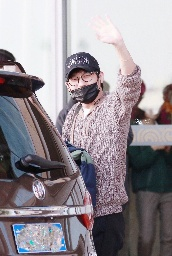

Sample image without mask


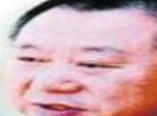

In [ ]:
mask_images = []
no_mask_images = []

dataset_base_path = os.path.join(os.getcwd(), 'Dataset')
mask_paths = os.listdir(os.path.join(dataset_base_path, 'with_mask'))
mask_paths = [ os.path.join(dataset_base_path, 'with_mask', img) for img in mask_paths ]

# No_mask label zero
no_mask_paths = os.listdir(os.path.join(dataset_base_path, 'without_mask'))
no_mask_paths = [ os.path.join(dataset_base_path, 'without_mask', img) for img in no_mask_paths ]

total_mask_number = len(mask_paths)
total_no_mask_number = len(no_mask_paths)
total_imgs = total_mask_number + total_no_mask_number

print(f'Total Mask: {total_mask_number}\nTotal No Mask: {total_no_mask_number}')

# Display sample with index 950 for validation
image_index = 950
print('Sample image with mask')
display(Image(mask_paths[image_index]))
print('Sample image without mask')
display(Image(no_mask_paths[image_index]))  

True


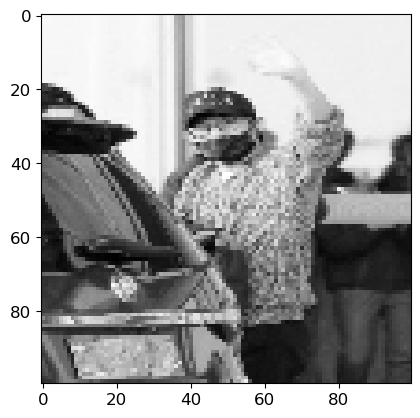

(0, 1)


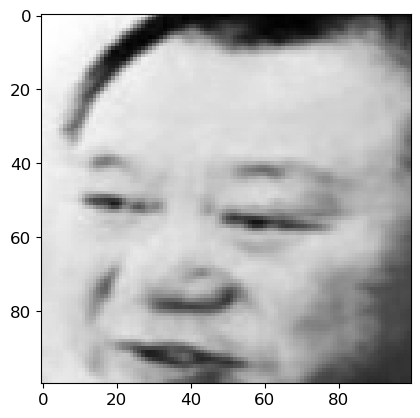

(1, 0)


In [ ]:
# DATASET
X_path = []
y = []

# mask (0,1) 
# no_mask (1,0)

index = 0
for m in range(total_mask_number):
    X_path.append(mask_paths[m])
    y.append((0,1))
    index += 1

for n in range(total_no_mask_number):
    X_path.append(no_mask_paths[n])
    y.append((1,0))
    index += 1

print(index == total_imgs)

# create image representation

# Transform to gray scale
# Resize to 100x100 and values in range [0,1]

def preprocess_image(path):
    img = cv2.imread(path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    final_img = cv2.resize(gray_img, (100,100))
    return final_img/255

sample = X_path[image_index]
result = preprocess_image(sample)
plt.imshow(result, cmap='gray')
plt.show()
print(y[image_index])

sample2 = X_path[image_index + 5521]
result2 = preprocess_image(sample2)
plt.imshow(result2, cmap='gray')
plt.show()
print(y[image_index + 5521])

X_pre = np.array([preprocess_image(img) for img in X_path])

# Reshape image to CNN expected format 1 channel (grey)
X_pre = np.reshape(X_pre,(X_pre.shape[0],100,100,1))

y = np.array(y)

In [ ]:
# SPLITE TRAINING, TESTING AND VALIDATION

X_train, X_test, y_train, y_test = train_test_split(X_pre, y, train_size=0.9, random_state=61, shuffle=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, random_state=61, shuffle=True)

print( f'X_train: {X_train.shape} Y_train: {y_train.shape}')
print( f'X_val: {X_val.shape} Y_val: {y_val.shape}')
print( f'X_test: {X_test.shape} Y_test: {y_test.shape}')


X_train: (7949, 100, 100, 1) Y_train: (7949, 2)
X_val: (1988, 100, 100, 1) Y_val: (1988, 2)
X_test: (1105, 100, 100, 1) Y_test: (1105, 2)


### Modeling

In [ ]:
# Dataset shape = Num Imgs x 100 x 100 x 1 channel

model = keras.models.Sequential()
model.add(keras.layers.Input((100,100,1), name='Input'))
model.add(keras.layers.Conv2D(filters=200, kernel_size=3, padding='valid', activation='relu', name='Conv2D-200'))
model.add(keras.layers.MaxPool2D(pool_size=3))
model.add(keras.layers.Conv2D(filters=100, kernel_size=3, padding='valid', activation='relu', name='Conv2D-100'))
model.add(keras.layers.MaxPool2D(pool_size=3))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units= 64, activation="relu", name='Dense64'))
model.add(keras.layers.Dense(units= 2, activation="softmax", name='Output'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D-200 (Conv2D)         (None, 98, 98, 200)       2000      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 200)      0         
 )                                                               
                                                                 
 Conv2D-100 (Conv2D)         (None, 30, 30, 100)       180100    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 100)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 Dense64 (Dense)             (None, 64)                6

Epoch 1/5
249/249 [==============================] - 52s 207ms/step - loss: 0.4103 - accuracy: 0.8183 - val_loss: 0.3163 - val_accuracy: 0.8587
Epoch 2/5
249/249 [==============================] - 50s 199ms/step - loss: 0.2020 - accuracy: 0.9231 - val_loss: 0.1674 - val_accuracy: 0.9437
Epoch 3/5
249/249 [==============================] - 52s 208ms/step - loss: 0.1408 - accuracy: 0.9472 - val_loss: 0.1756 - val_accuracy: 0.9457
Epoch 4/5
249/249 [==============================] - 49s 198ms/step - loss: 0.1076 - accuracy: 0.9625 - val_loss: 0.1564 - val_accuracy: 0.9547
Epoch 5/5
35/35 [==============================] - 2s 48ms/step - loss: 0.1484 - accuracy: 0.9502


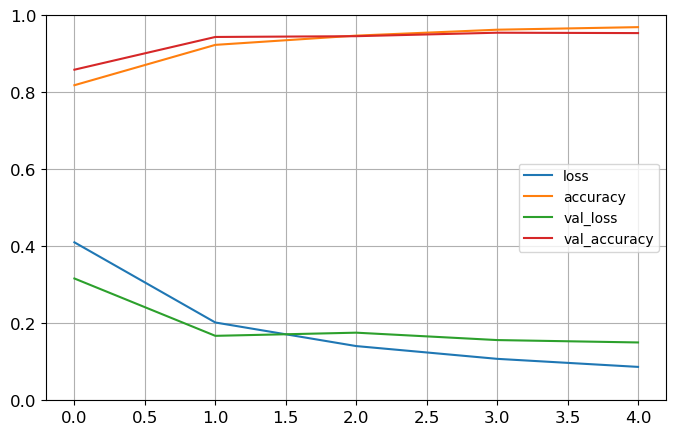

INFO:tensorflow:Assets written to: ./mask_detection_model\assets


INFO:tensorflow:Assets written to: ./mask_detection_model\assets


In [ ]:
# Use model_checkpoint as recommended in the paper

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./checkpoint',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Monitor model training and save the best version
model_history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val),
                          callbacks=[checkpoint_callback])

model_score = model.evaluate(X_test, y_test)

# Plot Loss Score and Accuracy
pd.DataFrame(model_history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# Save model
model.save('./mask_detection_model')



In [ ]:
# TESTING
# Load model
mask_detection_model = keras.models.load_model('./mask_detection_model')

# Load weights
mask_detection_model.load_weights('./checkpoint')

Sample Index: [168, 972, 382, 729, 556, 907, 938, 871, 171, 617, 502, 400, 1031, 953, 893, 337]
1/1 [==============================] - 0s 34ms/step


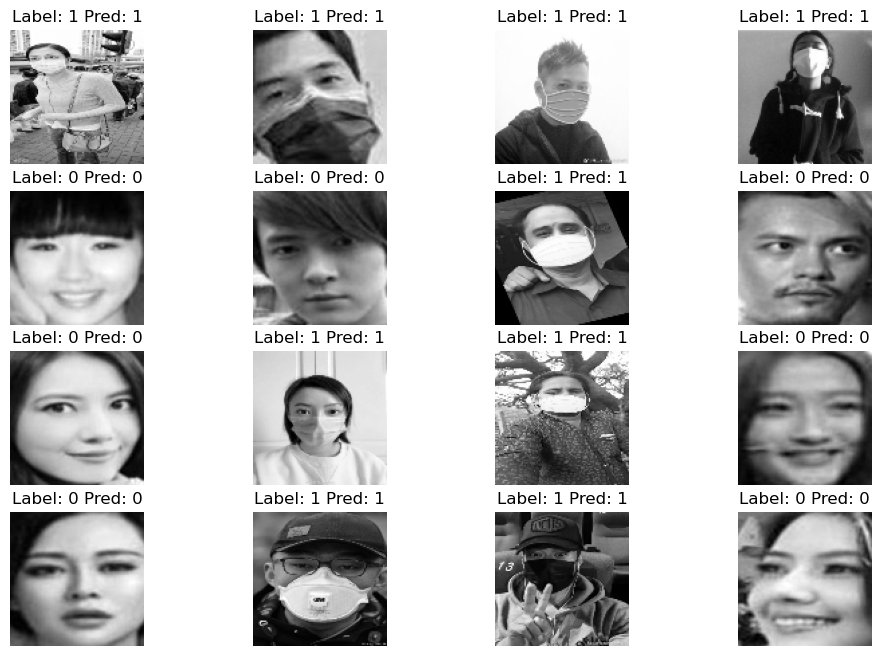

In [ ]:
# Display sample results

rows = 4
columns = 4

sample_indexes = [random.randrange(0, len(X_test)) for _ in range(rows*columns)]
print(f'Sample Index: {sample_indexes}')

# extract a few samples from testing set
X_sample = X_test[sample_indexes] 
y_sample = y_test[sample_indexes]
y_pred = mask_detection_model.predict(X_sample)
y_pred = [np.argmax(p) for p in y_pred]

plt.figure(figsize=(12,8))
img_index = 0
for row in range(rows):
    for col in range(columns):
        plt.subplot(rows, columns, img_index+1)
        plt.imshow(X_sample[img_index], cmap='gray')
        plt.title(f'Label: {np.argmax(y_sample[img_index])} Pred: {y_pred[img_index]}')
        plt.axis("off")
        img_index += 1
plt.show()